### Baseball Simulation with DuckDB on Lahnman Database

In this report, we will attempt to simulate a statistically "average" baseball game, through using the Lahman database of games

ReadMe file: https://www.seanlahman.com/files/database/readme2021.txt

https://pybbda.readthedocs.io/en/stable/auto_examples/example_run_expectancy.html#sphx-glr-download-auto-examples-example-run-expectancy-py

https://pypi.org/project/pybbda/

In [2]:
#pip install -r requirements.txt

     |████████████████████████████████| 11.3 MB 24.0 MB/s            �████▍                   | 4.4 MB 24.0 MB/s eta 0:00:01
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 16.8 MB 75.9 MB/s            
  Created wheel for duckdb: filename=duckdb-0.3.3-cp39-cp39-linux_x86_64.whl size=12926964 sha256=9de64321724f5e971ae86857095f420cceae76ac018ef7235ebaec369e3c3a85
  Stored in directory: /home/jovyan/.cache/pip/wheels/37/47/74/8419272484edff0f026281885b65610b5c28803492fa7d30d0
Successfully built duckdb
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
geopandas 0.11.1 requires fiona>=1.8, which is not installed.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
#import shutil
#dir_name = "/home/jovyan/work/BigData/lahnman-to-duckdb"
#output_filename = 'zipped_work'
#shutil.make_archive(output_filename, 'zip', dir_name)

In [3]:
import csv
from importlib.resources import files
from itertools import chain
from pathlib import PosixPath

import duckdb
import os

In [9]:
os.getcwd()
%cd "/home/jovyan/work/BigDataFInalProject/"

/home/jovyan/work/BigDataFInalProject


In [10]:
SQL = os.listdir('src/sql/')
CORE = os.listdir('src/lahnman/core/')
CONTRIB = os.listdir('src/lahnman/contrib/')
TMP = os.listdir('src/tmp/')

In [11]:
TABLE_ORDER = ['src/lahnman/core/people', 'src/lahnman/core/parks', 'src/lahnman/core/teamsfranchises', 'src/lahnman/core/teams',
               'src/lahnman/contrib/salaries', 'src/lahnman/contrib/schools', 'src/lahnman/core/allstarfull', 'src/lahnman/core/appearances',
               'src/lahnman/contrib/awardsmanagers', 'src/lahnman/contrib/awardsplayers', 'src/lahnman/contrib/awardssharemanagers', 
               'src/lahnman/contrib/awardsshareplayers', 'src/lahnman/core/batting', 'src/lahnman/core/battingpost',
               'src/lahnman/contrib/collegeplaying', 'src/lahnman/core/fielding', 'src/lahnman/core/fieldingof', 
               'src/lahnman/core/fieldingofsplit', 'src/lahnman/core/fieldingpost', 'src/lahnman/contrib/halloffame',
               'src/lahnman/core/homegames','src/lahnman/core/managers', 'src/lahnman/core/managershalf', 'src/lahnman/core/pitching',
               'src/lahnman/core/pitchingpost', 'src/lahnman/core/seriespost', 'src/lahnman/core/teamshalf']

In [38]:
def open_query(fname: PosixPath) -> str:
    with open(fname) as f:
        query = f.read()
    return query


def parse_query_columns(query_path: PosixPath) -> list[str]:
    """Return a list of columns for a given create table statement"""
    cols = []
    query = open_query(query_path)
    if not query.strip().startswith('CREATE TABLE'):
        return cols

    for row in query.split('\n'):
        if row.strip().startswith('"'):
            cols.append(row.strip().split('"')[1])
    return cols


def create_table_data_mapping() -> dict:
    """Return mapping of all table names -> query_path, file_path, create statement columns"""
    core = ['src/lahnman/core/' +  each for each in CORE]
    contrib = ['src/lahnman/contrib/' + each for each in CONTRIB]
    queries = ['src/sql/' + each for each in SQL]
    core.extend(contrib)
    files = core.copy()

    d = {}
    for fname, query in zip(files, queries):  # excludes final index query bc there is no associated file path
        name = fname.replace('.csv', '').lower()

        d[name] = {
            'query_path': query,
            'file_path': fname,
            'cols': parse_query_columns(query),
        }

    return d


def load_all_create_statements(mapping: dict):
    """Join all create statements into a single string"""
    all_queries = ''
    for table in TABLE_ORDER:
        all_queries += open_query(mapping.get(table)['query_path']) + '\n'
    return all_queries


def increment_and_save_csv(fname: PosixPath, fout: PosixPath) -> None:
    """Load csv, add zero-index "ID" column, increment starting at 1, return header and incremented data tuple"""
    results = []

    with open(fout, 'wt') as fo:
        csvwriter = csv.writer(fo)

        with open(fname) as f:
            csvreader = csv.reader(f)
            header = ['ID'] + next(csvreader)
            csvwriter.writerow(header)

            for i, row in enumerate(csvreader, start=1):
                csvwriter.writerow([i] + row)


def main():
    conn = duckdb.connect(database='lahnman.duckdb')
    mapping = create_table_data_mapping()

    create_statements = load_all_create_statements(mapping)
    
    create_statements = create_statements.replace('\n', '')
    create_statements = create_statements.replace('"', '')
    create_statements = ' '.join(create_statements.split())
    
    conn.execute('BEGIN TRANSACTION')
    conn.execute(create_statements)
    conn.execute('COMMIT')
    
    conn.execute('BEGIN TRANSACTION')
    for table in TABLE_ORDER:
        d = mapping.get(table)
        print(table)

        file_path = d['file_path']
        tmp_path = TMP.joinpath(file_path.name)

        # re-write file in tmp/ with ID col and incremented value
        increment_and_save_csv(file_path, tmp_path)

        cols = [c for c in d['cols'] if '_ID' not in c]  # trim foreign keys but leave primary ID

        conn.execute(f"COPY {table}({','.join(cols)}) FROM '{str(tmp_path)}' (DELIMITER ',', HEADER 1);")
    conn.execute('COMMIT')

    # final index query
    conn.execute(open_query(SQL.joinpath('zzz_indicies.sql')))

In [33]:
create_statements = 'CREATE TABLE people (playerID INTEGER NOT NULL, birthYear INTEGER NOT NULL); CREATE TABLE teamsfranchises ( ID INTEGER NOT NULL, franchID VARCHAR(50) NULL, franchName VARCHAR(50) NULL, active CHARACTER(1) NULL, NAassoc VARCHAR(3) NULL, PRIMARY KEY (ID));CREATE TABLE teams ( ID INTEGER NOT NULL, yearID SMALLINT NOT NULL, lgID CHARACTER(2) NULL, teamID CHARACTER(3) NOT NULL, franchID VARCHAR(3) NULL, divID CHARACTER(1) NULL, div_ID INTEGER NULL, teamRank SMALLINT NULL, G SMALLINT NULL, Ghome SMALLINT NULL, W SMALLINT NULL, L SMALLINT NULL, DivWin VARCHAR(1) NULL, WCWin VARCHAR(1) NULL, LgWin VARCHAR(1) NULL, WSWin VARCHAR(1) NULL, R SMALLINT NULL, AB SMALLINT NULL, H SMALLINT NULL, B2 SMALLINT NULL, B3 SMALLINT NULL, HR SMALLINT NULL, BB SMALLINT NULL, SO SMALLINT NULL, SB SMALLINT NULL, CS SMALLINT NULL, HBP SMALLINT NULL, SF SMALLINT NULL, RA SMALLINT NULL, ER SMALLINT NULL, ERA DOUBLE NULL, CG SMALLINT NULL, SHO SMALLINT NULL, SV SMALLINT NULL, IPouts INTEGER NULL, HA SMALLINT NULL, HRA SMALLINT NULL, BBA SMALLINT NULL, SOA SMALLINT NULL, E INTEGER NULL, DP INTEGER NULL, FP DOUBLE NULL, name VARCHAR(50) NULL, park VARCHAR(255) NULL, attendance INTEGER NULL, BPF INTEGER NULL, PPF INTEGER NULL, teamIDBR VARCHAR(3) NULL, teamIDlahman45 VARCHAR(3) NULL, teamIDretro VARCHAR(3) NULL, PRIMARY KEY (ID), FOREIGN KEY(franchID) REFERENCES teamsfranchises (franchID) ON UPDATE NO ACTION ON DELETE NO ACTION);CREATE TABLE schools ( ID INTEGER NOT NULL, schoolID VARCHAR(15) NOT NULL, name_full VARCHAR(255) NULL, city VARCHAR(55) NULL, state VARCHAR(55) NULL, country VARCHAR(55) NULL, PRIMARY KEY (ID));CREATE TABLE parks ( ID INTEGER NOT NULL, parkalias VARCHAR(255) NULL, parkkey VARCHAR(255) NULL, parkname VARCHAR(255) NULL, city VARCHAR(255) NULL, state VARCHAR(255) NULL, country VARCHAR(255) NULL, PRIMARY KEY (ID));CREATE TABLE homegames ( ID INTEGER NOT NULL, yearkey INTEGER NULL, leaguekey CHARACTER(2) NULL, teamkey CHARACTER(3) NULL, team_ID INTEGER NULL, parkkey VARCHAR(255) NULL, park_ID INTEGER NULL, spanfirst VARCHAR(255) NULL, spanlast VARCHAR(255) NULL, games INTEGER NULL, openings INTEGER NULL, attendance INTEGER NULL, PRIMARY KEY (ID), FOREIGN KEY(team_ID) REFERENCES teams (ID) ON UPDATE NO ACTION ON DELETE NO ACTION, FOREIGN KEY(park_ID) REFERENCES parks (ID) ON UPDATE NO ACTION ON DELETE NO ACTION);CREATE TABLE awardssharemanagers ( ID INTEGER NOT NULL, awardID VARCHAR(25) NOT NULL, yearID SMALLINT NOT NULL, lgID CHARACTER(2) NOT NULL, playerID VARCHAR(10) NOT NULL, pointsWon SMALLINT NULL, pointsMax SMALLINT NULL, votesFirst SMALLINT NULL, PRIMARY KEY (ID), FOREIGN KEY(playerID) REFERENCES people (playerID) ON UPDATE NO ACTION ON DELETE NO ACTION);CREATE TABLE fieldingof ( ID INTEGER NOT NULL, playerID VARCHAR(9) NOT NULL, yearID SMALLINT NOT NULL, stint SMALLINT NOT NULL, Glf SMALLINT NULL, Gcf SMALLINT NULL, Grf SMALLINT NULL, PRIMARY KEY (ID), FOREIGN KEY(playerID) REFERENCES people (playerID) ON UPDATE NO ACTION ON DELETE NO ACTION);CREATE TABLE fieldingofsplit ( ID INTEGER NOT NULL, playerID VARCHAR(9) NOT NULL, yearID SMALLINT NOT NULL, stint SMALLINT NOT NULL, teamID CHARACTER(3) NULL, team_ID INTEGER NULL, lgID CHARACTER(2) NULL, POS VARCHAR(2) NOT NULL, G SMALLINT NULL, GS SMALLINT NULL, InnOuts SMALLINT NULL, PO SMALLINT NULL, A SMALLINT NULL, E SMALLINT NULL, DP SMALLINT NULL, PB SMALLINT NULL, WP SMALLINT NULL, SB SMALLINT NULL, CS SMALLINT NULL, ZR DOUBLE NULL, PRIMARY KEY (ID), FOREIGN KEY(team_ID) REFERENCES teams (ID) ON UPDATE NO ACTION ON DELETE NO ACTION, FOREIGN KEY(playerID) REFERENCES people (playerID) ON UPDATE NO ACTION ON DELETE NO ACTION);CREATE TABLE awardsplayers ( ID INTEGER NOT NULL, playerID VARCHAR(9) NOT NULL, awardID VARCHAR(255) NOT NULL, yearID SMALLINT NOT NULL, lgID CHARACTER(2) NULL, tie VARCHAR(1) NULL, notes VARCHAR(100) NULL, PRIMARY KEY (ID), FOREIGN KEY(playerID) REFERENCES people (playerID) ON UPDATE NO ACTION ON DELETE NO ACTION);CREATE TABLE pitchingpost ( ID INTEGER NOT NULL, playerID VARCHAR(9) NOT NULL, yearID SMALLINT NOT NULL, round VARCHAR(10) NOT NULL, teamID CHARACTER(3) NULL, team_ID INTEGER NULL, lgID CHARACTER(2) NULL, W SMALLINT NULL, L SMALLINT NULL, G SMALLINT NULL, GS SMALLINT NULL, CG SMALLINT NULL, SHO SMALLINT NULL, SV SMALLINT NULL, IPouts INTEGER NULL, H SMALLINT NULL, ER SMALLINT NULL, HR SMALLINT NULL, BB SMALLINT NULL, SO SMALLINT NULL, BAOpp DOUBLE NULL, ERA DOUBLE NULL, IBB SMALLINT NULL, WP SMALLINT NULL, HBP SMALLINT NULL, BK SMALLINT NULL, BFP SMALLINT NULL, GF SMALLINT NULL, R SMALLINT NULL, SH SMALLINT NULL, SF SMALLINT NULL, GIDP SMALLINT NULL, PRIMARY KEY (ID), FOREIGN KEY(team_ID) REFERENCES teams (ID) ON UPDATE NO ACTION ON DELETE NO ACTION, FOREIGN KEY(playerID) REFERENCES people (playerID) ON UPDATE NO ACTION ON DELETE NO ACTION);CREATE TABLE managershalf ( ID INTEGER NOT NULL, playerID VARCHAR(10) NOT NULL, yearID SMALLINT NOT NULL, teamID CHARACTER(3) NOT NULL, team_ID INTEGER NULL, lgID CHARACTER(2) NULL, inseason SMALLINT NULL, half SMALLINT NOT NULL, G SMALLINT NULL, W SMALLINT NULL, L SMALLINT NULL, teamRank SMALLINT NULL, PRIMARY KEY (ID), FOREIGN KEY(team_ID) REFERENCES teams (ID) ON UPDATE NO ACTION ON DELETE NO ACTION, FOREIGN KEY(playerID) REFERENCES people (playerID) ON UPDATE NO ACTION ON DELETE NO ACTION);CREATE TABLE teamshalf ( ID INTEGER NOT NULL, yearID SMALLINT NOT NULL, lgID CHARACTER(2) NOT NULL, teamID CHARACTER(3) NOT NULL, team_ID INTEGER NULL, Half VARCHAR(1) NOT NULL, divID CHARACTER(1) NULL, div_ID INTEGER NULL, DivWin VARCHAR(1) NULL, teamRank SMALLINT NULL, G SMALLINT NULL, W SMALLINT NULL, L SMALLINT NULL, PRIMARY KEY (ID), FOREIGN KEY(team_ID) REFERENCES teams (ID) ON UPDATE NO ACTION ON DELETE NO ACTION);CREATE TABLE appearances ( ID INTEGER NOT NULL, yearID SMALLINT NOT NULL, teamID CHARACTER(3) NOT NULL, team_ID INTEGER NULL, lgID CHARACTER(2) NULL, playerID VARCHAR(9) NOT NULL, G_all SMALLINT NULL, GS SMALLINT NULL, G_batting SMALLINT NULL, G_defense SMALLINT NULL, G_p SMALLINT NULL, G_c SMALLINT NULL, G_1b SMALLINT NULL, G_2b SMALLINT NULL, G_3b SMALLINT NULL, G_ss SMALLINT NULL, G_lf SMALLINT NULL, G_cf SMALLINT NULL, G_rf SMALLINT NULL, G_of SMALLINT NULL, G_dh SMALLINT NULL, G_ph SMALLINT NULL, G_pr SMALLINT NULL, PRIMARY KEY (ID), FOREIGN KEY(team_ID) REFERENCES teams (ID) ON UPDATE NO ACTION ON DELETE NO ACTION, FOREIGN KEY(playerID) REFERENCES people (playerID) ON UPDATE NO ACTION ON DELETE NO ACTION);CREATE TABLE salaries ( ID INTEGER NOT NULL, yearID SMALLINT NOT NULL, teamID CHARACTER(3) NOT NULL, team_ID INTEGER NULL, lgID CHARACTER(2) NOT NULL, playerID VARCHAR(9) NOT NULL, salary DOUBLE NULL, PRIMARY KEY (ID), FOREIGN KEY(team_ID) REFERENCES teams (ID) ON UPDATE NO ACTION ON DELETE NO ACTION, FOREIGN KEY(playerID) REFERENCES people (playerID) ON UPDATE NO ACTION ON DELETE NO ACTION);CREATE TABLE fieldingpost ( ID INTEGER NOT NULL, playerID VARCHAR(9) NOT NULL, yearID SMALLINT NOT NULL, teamID CHARACTER(3) NULL, team_ID INTEGER NULL, lgID CHARACTER(2) NULL, round VARCHAR(10) NOT NULL, POS VARCHAR(2) NOT NULL, G SMALLINT NULL, GS SMALLINT NULL, InnOuts SMALLINT NULL, PO SMALLINT NULL, A SMALLINT NULL, E SMALLINT NULL, DP SMALLINT NULL, TP SMALLINT NULL, PB SMALLINT NULL, SB SMALLINT NULL, CS SMALLINT NULL, PRIMARY KEY (ID), FOREIGN KEY(team_ID) REFERENCES teams (ID) ON UPDATE NO ACTION ON DELETE NO ACTION, FOREIGN KEY(playerID) REFERENCES people (playerID) ON UPDATE NO ACTION ON DELETE NO ACTION);CREATE TABLE pitching ( ID INTEGER NOT NULL, playerID VARCHAR(9) NOT NULL, yearID SMALLINT NOT NULL, stint SMALLINT NOT NULL, teamID CHARACTER(3) NULL, team_ID INTEGER NULL, lgID CHARACTER(2) NULL, W SMALLINT NULL, L SMALLINT NULL, G SMALLINT NULL, GS SMALLINT NULL, CG SMALLINT NULL, SHO SMALLINT NULL, SV SMALLINT NULL, IPouts INTEGER NULL, H SMALLINT NULL, ER SMALLINT NULL, HR SMALLINT NULL, BB SMALLINT NULL, SO SMALLINT NULL, BAOpp DOUBLE NULL, ERA DOUBLE NULL, IBB SMALLINT NULL, WP SMALLINT NULL, HBP SMALLINT NULL, BK SMALLINT NULL, BFP SMALLINT NULL, GF SMALLINT NULL, R SMALLINT NULL, SH SMALLINT NULL, SF SMALLINT NULL, GIDP SMALLINT NULL, PRIMARY KEY (ID), FOREIGN KEY(team_ID) REFERENCES teams (ID) ON UPDATE NO ACTION ON DELETE NO ACTION, FOREIGN KEY(playerID) REFERENCES people (playerID) ON UPDATE NO ACTION ON DELETE NO ACTION);CREATE TABLE seriespost ( ID INTEGER NOT NULL, yearID SMALLINT NOT NULL, round VARCHAR(5) NOT NULL, teamIDwinner VARCHAR(3) NULL, lgIDwinner VARCHAR(2) NULL, team_IDwinner INTEGER NULL, teamIDloser VARCHAR(3) NULL, team_IDloser INTEGER NULL, lgIDloser VARCHAR(2) NULL, wins SMALLINT NULL, losses SMALLINT NULL, ties SMALLINT NULL, PRIMARY KEY (ID), FOREIGN KEY(team_IDwinner) REFERENCES teams (ID) ON UPDATE NO ACTION ON DELETE NO ACTION, FOREIGN KEY(team_IDloser) REFERENCES teams (ID) ON UPDATE NO ACTION ON DELETE NO ACTION);CREATE TABLE awardsshareplayers ( ID INTEGER NOT NULL, awardID VARCHAR(25) NOT NULL, yearID SMALLINT NOT NULL, lgID CHARACTER(2) NOT NULL, playerID VARCHAR(9) NOT NULL, pointsWon DOUBLE NULL, pointsMax SMALLINT NULL, votesFirst DOUBLE NULL, PRIMARY KEY (ID), FOREIGN KEY(playerID) REFERENCES people (playerID) ON UPDATE NO ACTION ON DELETE NO ACTION);CREATE TABLE managers ( ID INTEGER NOT NULL, playerID VARCHAR(10) NULL, yearID SMALLINT NOT NULL, teamID CHARACTER(3) NOT NULL, team_ID INTEGER NULL, lgID CHARACTER(2) NULL, inseason SMALLINT NOT NULL, G SMALLINT NULL, W SMALLINT NULL, L SMALLINT NULL, teamRank SMALLINT NULL, plyrMgr VARCHAR(1) NULL, PRIMARY KEY (ID), FOREIGN KEY(team_ID) REFERENCES teams (ID) ON UPDATE NO ACTION ON DELETE NO ACTION, FOREIGN KEY(playerID) REFERENCES people (playerID) ON UPDATE NO ACTION ON DELETE NO ACTION);CREATE TABLE collegeplaying ( ID INTEGER NOT NULL, playerID VARCHAR(9) NOT NULL, schoolID VARCHAR(15) NULL, yearID SMALLINT NULL, PRIMARY KEY (ID), FOREIGN KEY(schoolID) REFERENCES schools (schoolID) ON UPDATE NO ACTION ON DELETE NO ACTION, FOREIGN KEY(playerID) REFERENCES people (playerID) ON UPDATE NO ACTION ON DELETE NO ACTION);CREATE TABLE fielding ( ID INTEGER NOT NULL, playerID VARCHAR(9) NOT NULL, yearID SMALLINT NOT NULL, stint SMALLINT NOT NULL, teamID CHARACTER(3) NULL, team_ID INTEGER NULL, lgID CHARACTER(2) NULL, POS VARCHAR(2) NOT NULL, G SMALLINT NULL, GS SMALLINT NULL, InnOuts SMALLINT NULL, PO SMALLINT NULL, A SMALLINT NULL, E SMALLINT NULL, DP SMALLINT NULL, PB SMALLINT NULL, WP SMALLINT NULL, SB SMALLINT NULL, CS SMALLINT NULL, ZR DOUBLE NULL, PRIMARY KEY (ID), FOREIGN KEY(team_ID) REFERENCES teams (ID) ON UPDATE NO ACTION ON DELETE NO ACTION, FOREIGN KEY(playerID) REFERENCES people (playerID) ON UPDATE NO ACTION ON DELETE NO ACTION);CREATE TABLE battingpost ( ID INTEGER NOT NULL, yearID SMALLINT NOT NULL, round VARCHAR(10) NOT NULL, playerID VARCHAR(9) NOT NULL, teamID CHARACTER(3) NULL, team_ID INTEGER NULL, lgID CHARACTER(2) NULL, G SMALLINT NULL, AB SMALLINT NULL, R SMALLINT NULL, H SMALLINT NULL, B2 SMALLINT NULL, B3 SMALLINT NULL, HR SMALLINT NULL, RBI SMALLINT NULL, SB SMALLINT NULL, CS SMALLINT NULL, BB SMALLINT NULL, SO SMALLINT NULL, IBB SMALLINT NULL, HBP SMALLINT NULL, SH SMALLINT NULL, SF SMALLINT NULL, GIDP SMALLINT NULL, PRIMARY KEY (ID), FOREIGN KEY(team_ID) REFERENCES teams (ID) ON UPDATE NO ACTION ON DELETE NO ACTION, FOREIGN KEY(playerID) REFERENCES people (playerID) ON UPDATE NO ACTION ON DELETE NO ACTION);CREATE TABLE awardsmanagers ( ID INTEGER NOT NULL, playerID VARCHAR(10) NOT NULL, awardID VARCHAR(75) NOT NULL, yearID SMALLINT NOT NULL, lgID CHARACTER(2) NOT NULL, tie VARCHAR(1) NULL, notes VARCHAR(100) NULL, PRIMARY KEY (ID), FOREIGN KEY(playerID) REFERENCES people (playerID) ON UPDATE NO ACTION ON DELETE NO ACTION);CREATE INDEX allstarfull_team_ID ON allstarfull (team_ID);CREATE INDEX appearances_playerID ON appearances (playerID);CREATE INDEX appearances_team_ID ON appearances (team_ID);CREATE UNIQUE INDEX appearances_yearID ON appearances (yearID, teamID, playerID);CREATE UNIQUE INDEX batting_playerID ON batting (playerID, yearID, stint);CREATE INDEX batting_team_ID ON batting (team_ID);CREATE INDEX battingpost_playerID ON battingpost (playerID);CREATE INDEX battingpost_team_ID ON battingpost (team_ID);CREATE UNIQUE INDEX battingpost_yearID ON battingpost (yearID, round, playerID);CREATE INDEX collegeplaying_playerID ON collegeplaying (playerID);CREATE INDEX collegeplaying_schoolID ON collegeplaying (schoolID);CREATE UNIQUE INDEX fielding_playerID ON fielding (playerID, yearID, stint, POS);CREATE INDEX fielding_team_ID ON fielding (team_ID);CREATE UNIQUE INDEX fieldingof_playerID ON fieldingof (playerID, yearID, stint);CREATE UNIQUE INDEX fieldingofsplit_playerID ON fieldingofsplit (playerID, yearID, stint, POS);CREATE INDEX fieldingofsplit_team_ID ON fieldingofsplit (team_ID);CREATE UNIQUE INDEX fieldingpost_playerID ON fieldingpost (playerID, yearID, round, POS);CREATE INDEX fieldingpost_team_ID ON fieldingpost (team_ID);CREATE UNIQUE INDEX halloffame_playerID ON halloffame (playerID, yearid, votedBy);CREATE INDEX homegames_park_ID ON homegames (park_ID);CREATE INDEX homegames_team_ID ON homegames (team_ID);CREATE INDEX managers_playerID ON managers (playerID);CREATE INDEX managers_team_ID ON managers (team_ID);CREATE UNIQUE INDEX managers_yearID ON managers (yearID, teamID, inseason);CREATE UNIQUE INDEX managershalf_playerID ON managershalf (playerID, yearID, teamID, half);CREATE INDEX managershalf_team_ID ON managershalf (team_ID);CREATE UNIQUE INDEX pitching_playerID ON pitching (playerID, yearID, stint);CREATE INDEX pitching_team_ID ON pitching (team_ID);CREATE UNIQUE INDEX pitchingpost_playerID ON pitchingpost (playerID, yearID, round);CREATE INDEX pitchingpost_team_ID ON pitchingpost (team_ID);CREATE INDEX salaries_playerID ON salaries (playerID);CREATE INDEX salaries_team_ID ON salaries (team_ID);CREATE INDEX seriespost_team_IDloser ON seriespost (team_IDloser);CREATE INDEX seriespost_team_IDwinner ON seriespost (team_IDwinner);CREATE UNIQUE INDEX seriespost_yearID ON seriespost (yearID, round);CREATE INDEX teams_div_ID ON teams (div_ID);CREATE INDEX teams_franchID ON teams (franchID);CREATE INDEX teamshalf_div_ID ON teamshalf (div_ID);CREATE INDEX teamshalf_team_ID ON teamshalf (team_ID);CREATE TABLE batting ( ID INTEGER NOT NULL, playerID VARCHAR(9) NOT NULL, yearID SMALLINT NOT NULL, stint SMALLINT NOT NULL, teamID CHARACTER(3) NULL, team_ID INTEGER NULL, lgID CHARACTER(2) NULL, G SMALLINT NULL, AB SMALLINT NULL, R SMALLINT NULL, H SMALLINT NULL, B2 SMALLINT NULL, B3 SMALLINT NULL, HR SMALLINT NULL, RBI SMALLINT NULL, SB SMALLINT NULL, CS SMALLINT NULL, BB SMALLINT NULL, SO SMALLINT NULL, IBB SMALLINT NULL, HBP SMALLINT NULL, SH SMALLINT NULL, SF SMALLINT NULL, GIDP SMALLINT NULL, PRIMARY KEY (ID), FOREIGN KEY(team_ID) REFERENCES teams (ID) ON UPDATE NO ACTION ON DELETE NO ACTION, FOREIGN KEY(playerID) REFERENCES people (playerID) ON UPDATE NO ACTION ON DELETE NO ACTION);CREATE TABLE allstarfull ( ID INTEGER NOT NULL, playerID VARCHAR(9) NOT NULL, yearID SMALLINT NULL, gameNum SMALLINT NOT NULL, gameID VARCHAR(12) NULL, teamID CHARACTER(3) NULL, team_ID INTEGER NULL, lgID CHARACTER(2) NULL, GP SMALLINT NULL, startingPos SMALLINT NULL, PRIMARY KEY (ID), FOREIGN KEY(team_ID) REFERENCES teams (ID) ON UPDATE NO ACTION ON DELETE NO ACTION);CREATE TABLE halloffame ( ID INTEGER NOT NULL, playerID VARCHAR(10) NOT NULL, yearid SMALLINT NOT NULL, votedBy VARCHAR(64) NOT NULL, ballots SMALLINT NULL, needed SMALLINT NULL, votes SMALLINT NULL, inducted VARCHAR(1) NULL, category VARCHAR(20) NULL, needed_note VARCHAR(25) NULL, PRIMARY KEY (ID), FOREIGN KEY(playerID) REFERENCES people (playerID) ON UPDATE NO ACTION ON DELETE NO ACTION);'

In [42]:
create_statements

'CREATE TABLE people (playerID INTEGER NOT NULL, birthYear INTEGER NOT NULL); CREATE TABLE teamsfranchises ( ID INTEGER NOT NULL, franchID VARCHAR(50) NULL, franchName VARCHAR(50) NULL, active CHARACTER(1) NULL, NAassoc VARCHAR(3) NULL, PRIMARY KEY (ID));CREATE TABLE teams ( ID INTEGER NOT NULL, yearID SMALLINT NOT NULL, lgID CHARACTER(2) NULL, teamID CHARACTER(3) NOT NULL, franchID VARCHAR(3) NULL, divID CHARACTER(1) NULL, div_ID INTEGER NULL, teamRank SMALLINT NULL, G SMALLINT NULL, Ghome SMALLINT NULL, W SMALLINT NULL, L SMALLINT NULL, DivWin VARCHAR(1) NULL, WCWin VARCHAR(1) NULL, LgWin VARCHAR(1) NULL, WSWin VARCHAR(1) NULL, R SMALLINT NULL, AB SMALLINT NULL, H SMALLINT NULL, B2 SMALLINT NULL, B3 SMALLINT NULL, HR SMALLINT NULL, BB SMALLINT NULL, SO SMALLINT NULL, SB SMALLINT NULL, CS SMALLINT NULL, HBP SMALLINT NULL, SF SMALLINT NULL, RA SMALLINT NULL, ER SMALLINT NULL, ERA DOUBLE NULL, CG SMALLINT NULL, SHO SMALLINT NULL, SV SMALLINT NULL, IPouts INTEGER NULL, HA SMALLINT NULL, 

In [35]:
abbrev_create = 'CREATE TABLE people (playerID INTEGER NOT NULL, birthYear INTEGER NOT NULL); CREATE TABLE teamsfranchises ( ID INTEGER NOT NULL, franchID VARCHAR(3) NOT NULL, franchName VARCHAR(50) NULL, active CHARACTER(1) NULL, NAassoc VARCHAR(3) NULL, PRIMARY KEY (ID));CREATE TABLE teams ( ID INTEGER NOT NULL, yearID SMALLINT NOT NULL, lgID CHARACTER(2) NULL, teamID CHARACTER(3) NOT NULL, franchID VARCHAR(3) NULL, divID CHARACTER(1) NULL, div_ID INTEGER NULL, teamRank SMALLINT NULL, G SMALLINT NULL, Ghome SMALLINT NULL, W SMALLINT NULL, L SMALLINT NULL, DivWin VARCHAR(1) NULL, WCWin VARCHAR(1) NULL, LgWin VARCHAR(1) NULL, WSWin VARCHAR(1) NULL, R SMALLINT NULL, AB SMALLINT NULL, H SMALLINT NULL, B2 SMALLINT NULL, B3 SMALLINT NULL, HR SMALLINT NULL, BB SMALLINT NULL, SO SMALLINT NULL, SB SMALLINT NULL, CS SMALLINT NULL, HBP SMALLINT NULL, SF SMALLINT NULL, RA SMALLINT NULL, ER SMALLINT NULL, ERA DOUBLE NULL, CG SMALLINT NULL, SHO SMALLINT NULL, SV SMALLINT NULL, IPouts INTEGER NULL, HA SMALLINT NULL, HRA SMALLINT NULL, BBA SMALLINT NULL, SOA SMALLINT NULL, E INTEGER NULL, DP INTEGER NULL, FP DOUBLE NULL, name VARCHAR(50) NULL, park VARCHAR(255) NULL, attendance INTEGER NULL, BPF INTEGER NULL, PPF INTEGER NULL, teamIDBR VARCHAR(3) NULL, teamIDlahman45 VARCHAR(3) NULL, teamIDretro VARCHAR(3) NULL, PRIMARY KEY (ID), FOREIGN KEY(franchID) REFERENCES teamsfranchises (franchID) ON UPDATE NO ACTION ON DELETE NO ACTION);'

In [43]:
mapping = create_table_data_mapping()

In [44]:
mapping

{'src/lahnman/core/teams': {'query_path': 'src/sql/homegames.sql',
  'file_path': 'src/lahnman/core/Teams.csv',
  'cols': ['ID',
   'yearkey',
   'leaguekey',
   'teamkey',
   'team_ID',
   'parkkey',
   'park_ID',
   'spanfirst',
   'spanlast',
   'games',
   'openings',
   'attendance']},
 'src/lahnman/core/parks': {'query_path': 'src/sql/parks.sql',
  'file_path': 'src/lahnman/core/Parks.csv',
  'cols': ['ID',
   'parkalias',
   'parkkey',
   'parkname',
   'city',
   'state',
   'country']},
 'src/lahnman/core/batting': {'query_path': 'src/sql/appearances.sql',
  'file_path': 'src/lahnman/core/Batting.csv',
  'cols': ['ID',
   'yearID',
   'teamID',
   'team_ID',
   'lgID',
   'playerID',
   'G_all',
   'GS',
   'G_batting',
   'G_defense',
   'G_p',
   'G_c',
   'G_1b',
   'G_2b',
   'G_3b',
   'G_ss',
   'G_lf',
   'G_cf',
   'G_rf',
   'G_of',
   'G_dh',
   'G_ph',
   'G_pr']},
 'src/lahnman/core/fieldingof': {'query_path': 'src/sql/seriespost.sql',
  'file_path': 'src/lahnman/c

In [ ]:
con = duckdb.connect(database='my-lahman.duckdb', read_only=False)
mapping = create_table_data_mapping()
con.execute('BEGIN TRANSACTION')
con.execute(abbrev_create)
con.execute('COMMIT')

In [ ]:
if __name__ == '__main__':
    main()

In [46]:
con = sqlite3.connect("baseball.db")

In [50]:
cur = con.cursor()

In [52]:
res = cur.execute("SELECT PlayerID,yearID,AB,H FROM Batting;")
res.fetchone()

('aardsda01', 2004, 0, 0)

In [53]:
res2 = cur.execute("SELECT PlayerID,yearID,AB,H FROM Batting WHERE AB > 100 AND H > 0;")
res2.fetchone()

('aaronha01', 1954, 468, 131)

In [56]:
res3 = cur.execute("SELECT PlayerID,yearID,H/CAST(AB AS REAL) AS BattingAvg FROM Batting ORDER BY BattingAvg DESC LIMIT 10;")
res3.fetchall()

[('aberal01', 1957, 1.0),
 ('abernte02', 1960, 1.0),
 ('abramge01', 1923, 1.0),
 ('acklefr01', 1964, 1.0),
 ('allismi01', 1914, 1.0),
 ('altroni01', 1924, 1.0),
 ('altroni01', 1929, 1.0),
 ('anderla02', 1993, 1.0),
 ('archeji02', 1962, 1.0),
 ('averyst01', 2003, 1.0)]

In [90]:
res4 = cur.execute("SELECT playerID, SUM(salary) AS totalSalary FROM Salaries GROUP BY playerID HAVING totalSalary > 150000000")
res4.fetchall()

[('bondsba01', 188245322.0),
 ('griffke02', 151703682.0),
 ('jeterde01', 205430000.0),
 ('johnsra05', 175550019.0),
 ('maddugr01', 153845000.0),
 ('ramirma02', 204807769.0),
 ('rodrial01', 264416252.0),
 ('sheffga01', 168008550.0)]

In [61]:
res5 = cur.execute("SELECT nameLast,nameFirst,yearID,AB,H,salary FROM Master NATURAL JOIN Batting NATURAL JOIN Salaries ORDER BY salary DESC LIMIT 10;")
res5.fetchall()

[('Rodriguez', 'Alex', 2009, 444, 127, 33000000.0),
 ('Rodriguez', 'Alex', 2010, 522, 141, 33000000.0),
 ('Rodriguez', 'Alex', 2008, 510, 154, 28000000.0),
 ('Rodriguez', 'Alex', 2005, 605, 194, 26000000.0),
 ('Sabathia', 'C.C.', 2010, 5, 1, 24285714.0),
 ('Ramirez', 'Manny', 2009, 352, 102, 23854494.0),
 ('Giambi', 'Jason', 2007, 254, 60, 23428571.0),
 ('Giambi', 'Jason', 2008, 458, 113, 23428571.0),
 ('Rodriguez', 'Alex', 2007, 583, 183, 22708525.0),
 ('Jeter', 'Derek', 2010, 663, 179, 22600000.0)]

In [ ]:
pip install -U pybbda

In [161]:
from pybbda.data import LahmanData
lahman_data = LahmanData()

import pandas as pd
lahman_data.batting = pd.read_csv("Batting.csv")

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


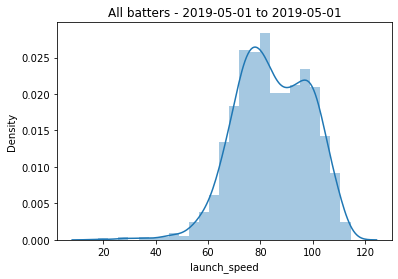

In [77]:
from matplotlib import pyplot as plt
import seaborn as sns
from pybbda.data import StatcastData

statcast_data = StatcastData()
ana_df = statcast_data.get_statcast_daily("batter", "2019-05-01", "2019-05-01")

plt.title("All batters - 2019-05-01 to 2019-05-01")

sns.distplot(ana_df.launch_speed)
plt.show()

In [162]:
import numpy as np

from pybbda.analysis.run_expectancy import MarkovSimulation
from pybbda.analysis.simulations import (
    BattingEventProbability,
    RunningEventProbability,
    Batter,
    Lineup,
    PlayerRegistry,
)

from pybbda.analysis.simulations.components.event import (
    _DEFAULT_RUNNING_EVENT_PROBS as DEFAULT_RUNNING_EVENT_PROBS,
)
from pybbda.analysis.simulations.constants import MAX_OUTS


def summarise_result(result):
    mean_score = result[-1].mean_score
    std_dev_score = result[-1].std_score
    print(
        "mean score per 27 outs = {:.4f}\n"
        "std. score per 27 outs = {:.4f}".format(
            mean_score / MAX_OUTS * 27, std_dev_score * np.sqrt(27 / MAX_OUTS)
        )
    )


def initialize_lineup():
    default_batting_probs = {
        "base_on_balls": 0.08,
        "single": 0.15,
        "double": 0.05,
        "triple": 0.005,
        "home_run": 0.03,
    }

    default_batter = Batter(
        player_id="default",
        batting_event_probabilities=BattingEventProbability(**default_batting_probs),
    )
    lineup = Lineup(lineup=[default_batter] * 9)
    return lineup


def update_lineup(lineup, lineup_slot, batter):
    lineup.set_lineup_slot(lineup_slot, batter)
    return lineup



In [163]:
res4 = cur.execute("SELECT playerID, yearID, SUM(salary) AS totalSalary FROM Salaries GROUP BY playerID HAVING totalSalary > 140000000")
res4.fetchall()

[('bondsba01', 1986, 188245322.0),
 ('delgaca01', 1994, 146299000.0),
 ('griffke02', 1989, 151703682.0),
 ('jeterde01', 1996, 205430000.0),
 ('johnsra05', 1989, 175550019.0),
 ('jonesch06', 1993, 141552133.0),
 ('maddugr01', 1988, 153845000.0),
 ('martipe02', 1993, 146259585.0),
 ('mussimi01', 1991, 144533619.0),
 ('ramirma02', 1993, 204807769.0),
 ('rodrial01', 1994, 264416252.0),
 ('sheffga01', 1989, 168008550.0)]

In [141]:
{k: v for k, v in player_registry.registry.items() if v.batting_event_probabilities.base_on_balls > .23}

{'bishoma01_1934': Batter(player_id='bishoma01_1934', batting_event_probabilities=BattingEventProbability(base_on_balls=0.2404692082111437, single=0.1495601173020528, double=0.03812316715542522, triple=0.002932551319648094, home_run=0.002932551319648094), running_event_probabilities=RunningEventProbability(first_to_third_on_single=0.26, first_to_home_on_single=0.01, first_to_home_on_double=0.41, second_to_home_on_single=0.6)),
 'bondsba01_2001': Batter(player_id='bondsba01_2001', batting_event_probabilities=BattingEventProbability(base_on_balls=0.26656626506024095, single=0.07379518072289157, double=0.04819277108433735, triple=0.0030120481927710845, home_run=0.10993975903614457), running_event_probabilities=RunningEventProbability(first_to_third_on_single=0.26, first_to_home_on_single=0.01, first_to_home_on_double=0.41, second_to_home_on_single=0.6)),
 'bondsba01_2002': Batter(player_id='bondsba01_2002', batting_event_probabilities=BattingEventProbability(base_on_balls=0.32352941176470

In [143]:
player_registry = PlayerRegistry()
player_registry.load_from_lahman()

running_event_probs = RunningEventProbability(*DEFAULT_RUNNING_EVENT_PROBS)
print("## default running probs:\n", running_event_probs, "\n")


markov_simulation = MarkovSimulation(termination_threshold=1e-4)


lineup = initialize_lineup()
result = markov_simulation(
    lineup=lineup, running_event_probabilities=running_event_probs
)
print("## markov simulation result for default game")
summarise_result(result)


lineup = update_lineup(lineup, 1, player_registry.registry["bondsba01_2001"])
lineup = update_lineup(lineup, 2, player_registry.registry["dietzdi01_1973"])
lineup = update_lineup(lineup, 3, player_registry.registry["willite01_1954"])
lineup = update_lineup(lineup, 4, player_registry.registry["fainfe01_1955"])
lineup = update_lineup(lineup, 5, player_registry.registry["bishoma01_1934"])
lineup = update_lineup(lineup, 6, player_registry.registry["ruthba01_1923"])
lineup = update_lineup(lineup, 7, player_registry.registry["robinya01_1890"])
lineup = update_lineup(lineup, 8, player_registry.registry["mcgrajo01_1899"])
lineup = update_lineup(lineup, 9, player_registry.registry["grandya01_2021"])

result = markov_simulation(
    lineup=lineup, running_event_probabilities=running_event_probs
)
print("## markov simulation result for filtration game")
summarise_result(result)

## default running probs:
 RunningEventProbability(first_to_third_on_single=0.26, first_to_home_on_single=0.01, first_to_home_on_double=0.41, second_to_home_on_single=0.6) 

## markov simulation result for default game
mean score per 27 outs = 4.2242
std. score per 27 outs = 3.0161
## markov simulation result for filtration game
mean score per 27 outs = 10.7012
std. score per 27 outs = 5.5100


In [149]:
{k: v for k, v in player_registry.registry.items() if v.batting_event_probabilities.home_run > .085}

{'aaronha01_1973': Batter(player_id='aaronha01_1973', batting_event_probabilities=BattingEventProbability(base_on_balls=0.14623655913978495, single=0.13978494623655913, double=0.025806451612903226, triple=0.002150537634408602, home_run=0.08602150537634409), running_event_probabilities=RunningEventProbability(first_to_third_on_single=0.26, first_to_home_on_single=0.01, first_to_home_on_double=0.41, second_to_home_on_single=0.6)),
 'bondsba01_2001': Batter(player_id='bondsba01_2001', batting_event_probabilities=BattingEventProbability(base_on_balls=0.26656626506024095, single=0.07379518072289157, double=0.04819277108433735, triple=0.0030120481927710845, home_run=0.10993975903614457), running_event_probabilities=RunningEventProbability(first_to_third_on_single=0.26, first_to_home_on_single=0.01, first_to_home_on_double=0.41, second_to_home_on_single=0.6)),
 'garvemi01_2019': Batter(player_id='garvemi01_2019', batting_event_probabilities=BattingEventProbability(base_on_balls=0.114206128133

In [150]:
player_registry = PlayerRegistry()
player_registry.load_from_lahman()

running_event_probs = RunningEventProbability(*DEFAULT_RUNNING_EVENT_PROBS)
print("## default running probs:\n", running_event_probs, "\n")


markov_simulation = MarkovSimulation(termination_threshold=1e-4)


lineup = initialize_lineup()
result = markov_simulation(
    lineup=lineup, running_event_probabilities=running_event_probs
)
print("## markov simulation result for default game")
summarise_result(result)


lineup = update_lineup(lineup, 1, player_registry.registry["bondsba01_2001"])
lineup = update_lineup(lineup, 2, player_registry.registry["martijd02_2017"])
lineup = update_lineup(lineup, 3, player_registry.registry["mcgwima01_1995"])
lineup = update_lineup(lineup, 4, player_registry.registry["voitlu01_2020"])
lineup = update_lineup(lineup, 5, player_registry.registry["sosasa01_2001"])
lineup = update_lineup(lineup, 6, player_registry.registry["olsonma02_2017"])
lineup = update_lineup(lineup, 7, player_registry.registry["ruthba01_1920"])
lineup = update_lineup(lineup, 8, player_registry.registry["zuninmi01_2021"])
lineup = update_lineup(lineup, 9, player_registry.registry["willima04_1994"])

result = markov_simulation(
    lineup=lineup, running_event_probabilities=running_event_probs
)
print("## markov simulation result for filtration game")
summarise_result(result)

## default running probs:
 RunningEventProbability(first_to_third_on_single=0.26, first_to_home_on_single=0.01, first_to_home_on_double=0.41, second_to_home_on_single=0.6) 

## markov simulation result for default game
mean score per 27 outs = 4.2242
std. score per 27 outs = 3.0161
## markov simulation result for filtration game
mean score per 27 outs = 9.7030
std. score per 27 outs = 4.7298


In [159]:
{k: v for k, v in player_registry.registry.items() if (v.batting_event_probabilities.home_run < .01) & (v.batting_event_probabilities.base_on_balls < .01)& (v.batting_event_probabilities.base_on_balls < .01) & (v.batting_event_probabilities.single < .15)}

{'cassijo01_1875': Batter(player_id='cassijo01_1875', batting_event_probabilities=BattingEventProbability(base_on_balls=0.0, single=0.13297872340425532, double=0.02127659574468085, triple=0.010638297872340425, home_run=0.005319148936170213), running_event_probabilities=RunningEventProbability(first_to_third_on_single=0.26, first_to_home_on_single=0.01, first_to_home_on_double=0.41, second_to_home_on_single=0.6)),
 'dailyed01_1885': Batter(player_id='dailyed01_1885', batting_event_probabilities=BattingEventProbability(base_on_balls=0.0, single=0.14673913043478262, double=0.043478260869565216, triple=0.010869565217391304, home_run=0.005434782608695652), running_event_probabilities=RunningEventProbability(first_to_third_on_single=0.26, first_to_home_on_single=0.01, first_to_home_on_double=0.41, second_to_home_on_single=0.6)),
 'gerhajo01_1879': Batter(player_id='gerhajo01_1879', batting_event_probabilities=BattingEventProbability(base_on_balls=0.00949367088607595, single=0.145569620253164

In [160]:
player_registry = PlayerRegistry()
player_registry.load_from_lahman()

running_event_probs = RunningEventProbability(*DEFAULT_RUNNING_EVENT_PROBS)
print("## default running probs:\n", running_event_probs, "\n")


markov_simulation = MarkovSimulation(termination_threshold=1e-4)


lineup = initialize_lineup()
result = markov_simulation(
    lineup=lineup, running_event_probabilities=running_event_probs
)
print("## markov simulation result for default game")
summarise_result(result)


lineup = update_lineup(lineup, 1, player_registry.registry["weyhigu01_1888"])
lineup = update_lineup(lineup, 2, player_registry.registry["snydere01_1876"])
lineup = update_lineup(lineup, 3, player_registry.registry["rosemch01_1882"])
lineup = update_lineup(lineup, 4, player_registry.registry["powerdo01_1906"])
lineup = update_lineup(lineup, 5, player_registry.registry["mcgeaja01_1886"])
lineup = update_lineup(lineup, 6, player_registry.registry["johnsre02_2014"])
lineup = update_lineup(lineup, 7, player_registry.registry["hackeme01_1884"])
lineup = update_lineup(lineup, 8, player_registry.registry["gerhajo01_1879"])
lineup = update_lineup(lineup, 9, player_registry.registry["cassijo01_1875"])

result = markov_simulation(
    lineup=lineup, running_event_probabilities=running_event_probs
)
print("## markov simulation result for filtration game")
summarise_result(result)

## default running probs:
 RunningEventProbability(first_to_third_on_single=0.26, first_to_home_on_single=0.01, first_to_home_on_double=0.41, second_to_home_on_single=0.6) 

## markov simulation result for default game
mean score per 27 outs = 4.2242
std. score per 27 outs = 3.0161
## markov simulation result for filtration game
mean score per 27 outs = 1.2102
std. score per 27 outs = 1.4600


In [182]:
lahman_data.batting.loc[(lahman_data.batting.yearID == 2008) & (lahman_data.batting.teamID == "PHI") & (lahman_data.batting.G > 100)]

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
90255,brunter01,2008,1,PHI,NL,120,212,37,46,9,...,15.0,9.0,2.0,21,35.0,3.0,3.0,2.0,0.0,7.0
90272,burrepa01,2008,1,PHI,NL,157,536,74,134,33,...,86.0,0.0,0.0,102,136.0,8.0,1.0,0.0,6.0,10.0
90426,dobbsgr01,2008,1,PHI,NL,128,226,30,68,14,...,40.0,3.0,1.0,11,40.0,1.0,1.0,0.0,2.0,4.0
90487,felizpe01,2008,1,PHI,NL,133,425,43,106,19,...,58.0,0.0,0.0,33,54.0,3.0,0.0,3.0,2.0,14.0
90677,howarry01,2008,1,PHI,NL,162,610,105,153,26,...,146.0,1.0,1.0,81,199.0,17.0,3.0,0.0,6.0,11.0
90714,jenkige01,2008,1,PHI,NL,115,293,27,72,16,...,29.0,1.0,1.0,24,68.0,5.0,1.0,0.0,4.0,6.0
91182,rolliji01,2008,1,PHI,NL,137,556,76,154,38,...,59.0,47.0,3.0,58,55.0,7.0,5.0,3.0,3.0,11.0
91196,ruizca01,2008,1,PHI,NL,117,320,47,70,14,...,31.0,1.0,2.0,44,38.0,6.0,4.0,4.0,1.0,14.0
91374,utleych01,2008,1,PHI,NL,159,607,113,177,41,...,104.0,14.0,2.0,64,104.0,14.0,27.0,1.0,8.0,9.0
91393,victosh01,2008,1,PHI,NL,146,570,102,167,30,...,58.0,36.0,11.0,45,69.0,2.0,7.0,5.0,0.0,8.0


In [ ]:
lineup = update_lineup(lineup, 1, player_registry.registry["brunter01_2008"])
lineup = update_lineup(lineup, 2, player_registry.registry["burrepa01_2008"])
lineup = update_lineup(lineup, 3, player_registry.registry["victosh_2008"])
lineup = update_lineup(lineup, 4, player_registry.registry["felizpe01_2008"])
lineup = update_lineup(lineup, 5, player_registry.registry["howarry01_2008"])
lineup = update_lineup(lineup, 6, player_registry.registry["jenkige01_2008"])
lineup = update_lineup(lineup, 7, player_registry.registry["rolliji01_2008"])
lineup = update_lineup(lineup, 8, player_registry.registry["ruizca01_2008"])
lineup = update_lineup(lineup, 9, player_registry.registry["utleych01_2008"])

result = markov_simulation(
    lineup=lineup, running_event_probabilities=running_event_probs
)
print("## markov simulation result for filtration game")
summarise_result(result)

In [181]:
lineup = update_lineup(lineup, 1, player_registry.registry["bohmal01_2021"])
lineup = update_lineup(lineup, 2, player_registry.registry["gregodi01_2021"])
lineup = update_lineup(lineup, 3, player_registry.registry["harpebr03_2021"])
lineup = update_lineup(lineup, 4, player_registry.registry["herreod01_2021"])
lineup = update_lineup(lineup, 5, player_registry.registry["hoskirh01_2021"])
lineup = update_lineup(lineup, 6, player_registry.registry["mccutan01_2021"])
lineup = update_lineup(lineup, 7, player_registry.registry["millebr02_2021"])
lineup = update_lineup(lineup, 8, player_registry.registry["realmjt01_2021"])
lineup = update_lineup(lineup, 9, player_registry.registry["segurje01_2021"])

result = markov_simulation(
    lineup=lineup, running_event_probabilities=running_event_probs
)
print("## markov simulation result for filtration game")
summarise_result(result)

## markov simulation result for filtration game
mean score per 27 outs = 4.5441
std. score per 27 outs = 3.1753
